In [336]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [337]:
day_closes = Path('../data/day_close')
assert day_closes.exists()

tickers = [file.name.removesuffix('.csv') for file in day_closes.iterdir()]
len(tickers)

246

In [338]:
def is_sorted(arr):
    return np.all(np.sort(arr) == arr)


dfs = {}
for ticker in tickers:
    df = pd.read_csv(day_closes / f'{ticker}.csv', parse_dates=[1]).set_index('TRADEDATE')
    assert np.all(df['BOARDID'] == 'TQBR')
    assert is_sorted(df.index)
    df = df.rename(columns={'CLOSE': ticker})
    dfs[ticker] = df[ticker]
len(dfs)

246

In [339]:
first_ticker = 'SBER'
second_ticker = 'ROSN'

first = dfs[first_ticker]
second = dfs[second_ticker]

print(f'len(first)={len(first)}, len(second)={len(second)}')
first = first[np.isin(first.index, second.index)]
second = second[np.isin(second.index, first.index)]
print(f'len(common) = {len(first)}')
print(f'From {first.index[0].strftime("%Y-%m-%d")} to {first.index[-1].strftime("%Y-%m-%d")}')
assert np.all(first.index == second.index)
assets_df = pd.concat((first, second), axis=1)
assets_df.head()

len(first)=2568, len(second)=2265
len(common) = 2265
From 2014-06-09 to 2023-06-01


,SBER,ROSN
TRADEDATE,,
2014-06-09,88.89,240.36
2014-06-10,88.99,242.80
2014-06-11,89.00,249.66
2014-06-16,84.85,253.30
2014-06-17,83.80,251.59


In [340]:
tickers = assets_df.columns.tolist()
assets_returns = assets_df.pct_change() * 100
day_distance = pd.to_timedelta((assets_returns.index[1:] - assets_returns.index[:-1]).total_seconds(), unit='s')
assets_returns = assets_returns.dropna()
assets_returns['day_distance'] = day_distance
assets_returns.head()

,SBER,ROSN,day_distance
TRADEDATE,,,
2014-06-10,0.112499,1.015144,1 days
2014-06-11,0.011237,2.825371,1 days
2014-06-16,-4.662921,1.457983,5 days
2014-06-17,-1.237478,-0.675089,1 days
2014-06-18,-0.035800,-0.286180,1 days


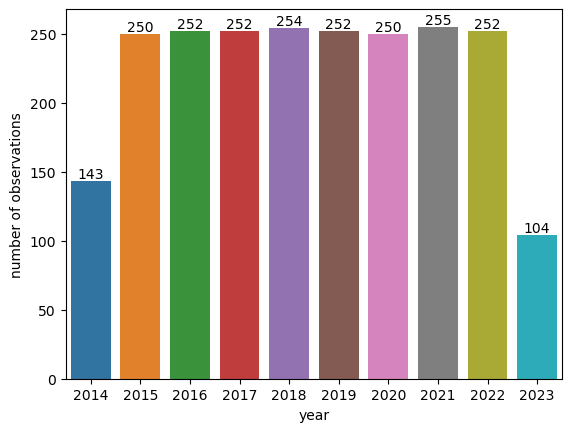

In [341]:
TRADE_DAYS_PER_YEAR = 252

observations_counts = assets_returns.groupby(pd.Grouper(freq='Y', level='TRADEDATE')).size()
ax = sns.barplot(x=observations_counts.index.year, y=observations_counts)
for i, v in enumerate(observations_counts.values):
    ax.text(i, v, str(v), ha='center', va='bottom')
plt.xlabel('year')
plt.ylabel('number of observations')
plt.show()

In [342]:
# convert to day returns
for ticker in tickers:
    assets_returns[f'{ticker}_corrected'] = assets_returns[ticker] / assets_returns['day_distance'].dt.days

In [343]:
assets_returns_corrected = assets_returns[[f'{ticker}_corrected' for ticker in tickers]].rename(columns={f'{ticker}_corrected': ticker for ticker in tickers})
assets_returns_corrected.head()

,SBER,ROSN
TRADEDATE,,
2014-06-10,0.112499,1.015144
2014-06-11,0.011237,2.825371
2014-06-16,-0.932584,0.291597
2014-06-17,-1.237478,-0.675089
2014-06-18,-0.035800,-0.286180


In [344]:
corr_matrix = assets_returns_corrected.corr()
cov_matrix = assets_returns_corrected.cov()
corr_matrix

,SBER,ROSN
SBER,1.000000,0.580848
ROSN,0.580848,1.000000


In [345]:
assets_returns_corrected.mean() * TRADE_DAYS_PER_YEAR

SBER    14.560186
ROSN    12.905394
dtype: float64

In [346]:
w_first = np.linspace(1, 0, 100).reshape(1, -1)
w = np.concatenate((w_first, 1 - w_first), axis=0)
w.shape

(2, 100)

In [347]:
mean_returns = (w * assets_returns_corrected.mean().values.reshape(-1, 1)).sum(axis=0) * TRADE_DAYS_PER_YEAR
std_returns = np.sqrt((w * (cov_matrix.values @ w)).sum(axis=0)) * np.sqrt(TRADE_DAYS_PER_YEAR)

In [348]:
# sanity check
N_OBSERVATION = 25
true_returns = (assets_returns_corrected.values * w[:, N_OBSERVATION]).sum(axis=1)
assert np.isclose(mean_returns[N_OBSERVATION], true_returns.mean() * TRADE_DAYS_PER_YEAR)
assert np.isclose(std_returns[N_OBSERVATION], true_returns.std() * np.sqrt(TRADE_DAYS_PER_YEAR), rtol=1e-3), f'{std_returns[N_OBSERVATION], true_returns.std()}'

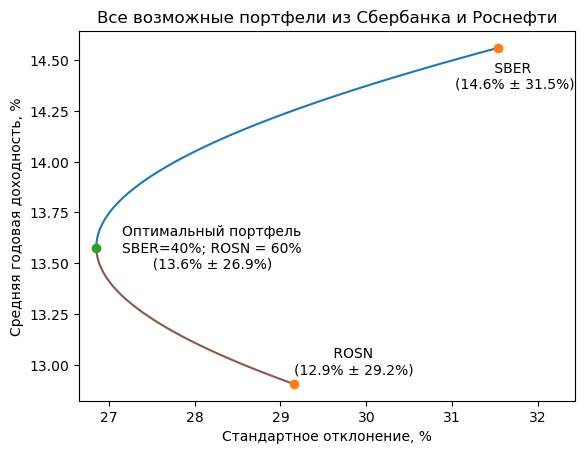

In [355]:
min_variance = np.argmin(std_returns)
plt.plot(std_returns[min_variance:], mean_returns[min_variance:], color='C5')
plt.plot(std_returns[:min_variance], mean_returns[:min_variance], color='C0')

plt.xlim(min(std_returns) - 0.2, max(std_returns) + 0.9)

plt.plot(std_returns[0], mean_returns[0], marker='o', color='C1')
plt.annotate(f'         {first_ticker}\n({mean_returns[0]:.1f}% ± {std_returns[0]:.1f}%)', (std_returns[0], mean_returns[0]), xytext=(std_returns[0] - 0.5, mean_returns[0] - 0.2))

plt.plot(std_returns[-1], mean_returns[-1], marker='o', color='C1')
plt.annotate(f'         {second_ticker}\n({mean_returns[-1]:.1f}% ± {std_returns[-1]:.1f}%)', (std_returns[-1], mean_returns[-1]), xytext=(std_returns[-1], mean_returns[-1] + 0.05))

plt.plot(std_returns[min_variance], mean_returns[min_variance], marker='o', color='C2')
plt.annotate(f'Оптимальный портфель\n{first_ticker}={w[0, min_variance]:.0%}; {second_ticker} = {w[1, min_variance]:.0%}\n       ({mean_returns[min_variance]:.1f}% ± {std_returns[min_variance]:.1f}%)', (std_returns[min_variance], mean_returns[min_variance]), xytext=(std_returns[min_variance] + 0.3, mean_returns[min_variance] - 0.1))


plt.xlabel('Стандартное отклонение, %')
plt.ylabel('Средняя годовая доходность, %')
plt.title('Все возможные портфели из Сбербанка и Роснефти')

plt.savefig('figures/optimal_portfolio.png', bbox_inches='tight')

plt.show()

Портфельный эффект – что это?

Многие из вас, наверное, знают про диверсификацию при инвестициях. Например, стоит купить акции компаний из разных отраслей. Если одна компания теряет в цене, то акции другой компании могут вырасти. Но как выбрать доли каждой компании в портфеле? Какая самая эффективная стратегия?

Чтобы ответить на эти вопросы, давайте разберемся с понятием риска. Каждый актив имеет среднюю доходность. Например, акции обычно дают большую доходность, чем облигации. Однако, у акций есть риски: доходность может быть выше или ниже средней. Средняя разница между средней доходностью и фактической называется стандартным отклонением доходности. Чем выше стандартное отклонение, тем больше риск вложения в этот актив, потому что вероятность получить доходность ниже средней увеличивается.

Теперь перейдем к составлению портфеля. Давайте рассмотрим две акции: Сбербанк и Роснефть. У каждой акции есть средняя доходность и стандартное отклонение. Также, доходности этих акций связаны друг с другом, что затрудняет составление диверсифицированного портфеля.

Давайте рассмотрим все возможные портфели, в которых Сбербанк занимает долю a%, а Роснефть – долю (100 - a)%. Посчитаем для этих портфелей среднюю доходность и стандартное отклонение доходности. На графике отложим по оси y среднюю доходность, а по оси x – стандартное отклонение. Оранжевыми точками отметим портфели, состоящие только из Сбербанка или Роснефти.

Можно заметить, что акции Сбербанка в среднем дают более высокую годовую доходность – 14.6%, но их стандартное отклонение доходности также очень большое – около 31.5%. Роснефть дает меньшую среднюю доходность, но при этом имеет более низкий риск.

Также из графика видно, что инвестировать все средства только в Роснефть нерационально. Если составить портфель из 60% Роснефти и 40% Сбербанка (зеленая точка), то у такого портфеля будет более высокая доходность и меньший риск. Все точки на коричневой кривой хуже точек на голубой кривой – это значит, что портфельный эффект позволяет получать более высокую доходность при том же риске.

В итоге, выбирая между точками на синей кривой, каждый должен решить для себя, насколько ему важен риск по сравнению со средней доходностью. Данный пример рассматривает только 2 акции. Но в портфель надо брать сразу много разных активов, потому что портфельный эффект будет работать еще лучше. О том, как можно математически учесть больше акций и собрать оптимальный портфель, будет в следующих постах.